# Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

# Analyzing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/DEMODAY/DEMODAY/train/'
validation_dir = '/content/drive/MyDrive/DEMODAY/DEMODAY/validation/'

row = 48
col = 48
classes = len(os.listdir('/content/drive/MyDrive/DEMODAY/DEMODAY/train/'))

In [4]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

validation_count = []
print("Test Set :")
for folder in os.listdir(validation_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(validation_dir+folder)), "images")
    validation_count.append(len(os.listdir(validation_dir+folder)))

Train Set :
fear folder contains		 4103 image
surprise folder contains		 3205 image
sad folder contains		 4938 image
angry folder contains		 3993 image
disgust folder contains		 436 image
neutral folder contains		 4982 image
happy folder contains		 7164 image

Test Set :
happy folder contains		 1825 images
disgust folder contains		 111 images
neutral folder contains		 1216 images
fear folder contains		 1028 images
surprise folder contains		 797 images
angry folder contains		 960 images
sad folder contains		 1139 images


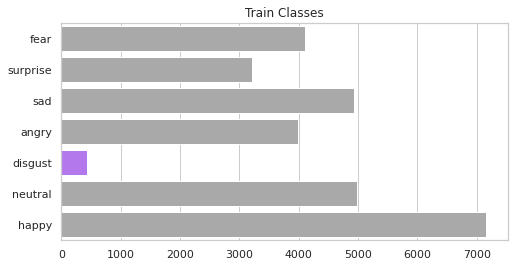

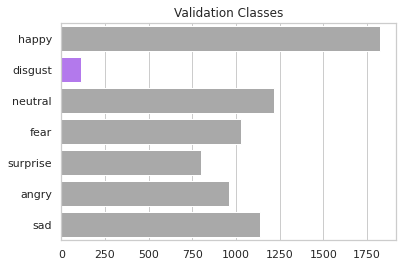

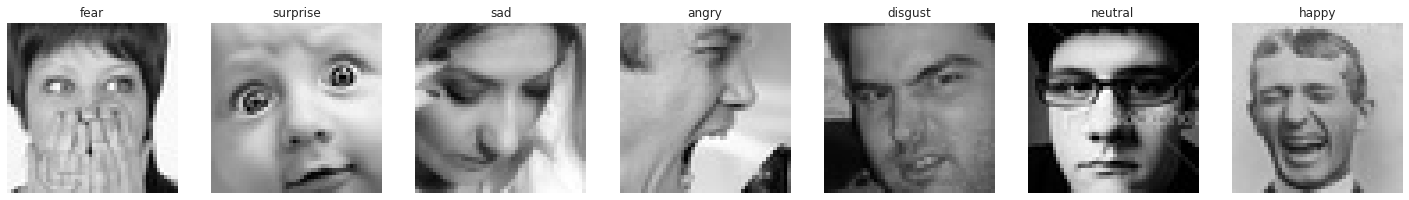

In [5]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(validation_dir),
                 x=validation_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Validation Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

# Preprocessing

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_set = validation_datagen.flow_from_directory(validation_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28821 images belonging to 7 classes.
Found 7076 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Model

In [8]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


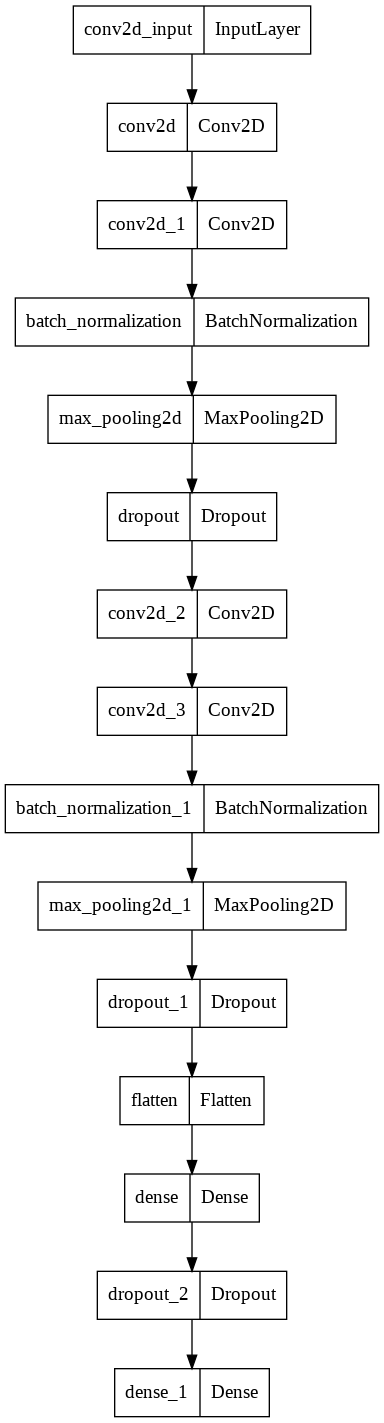

In [10]:
plot_model(fernet, show_layer_names=True)

# Checkpoint

In [11]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [12]:
training_set.n

28821

In [14]:
steps_per_epoch = 20
validation_steps = 20

hist = fernet.fit(x=training_set,
                  validation_data=validation_set,
                  epochs=10,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 4.1216 - accuracy: 0.2991
Epoch 1: val_loss did not improve from 4.21195
20/20 [==============================] - 227s 11s/step - loss: 4.1216 - accuracy: 0.2991 - val_loss: 4.3828 - val_accuracy: 0.1375 - lr: 2.0000e-05
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 4.1301 - accuracy: 0.2926
Epoch 2: val_loss did not improve from 4.21195
20/20 [==============================] - 214s 11s/step - loss: 4.1301 - accuracy: 0.2926 - val_loss: 4.4586 - val_accuracy: 0.1227 - lr: 2.0000e-05
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 4.1313 - accuracy: 0.2937
Epoch 3: val_loss did not improve from 4.21195
20/20 [==============================] - 197s 10s/step - loss: 4.1313 - accuracy: 0.2937 - val_loss: 4.4868 - val_accuracy: 0.1336 - lr: 2.0000e-05
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 4.1325 - accuracy: 0.2812
Epoch 4: val_loss did not improve from 

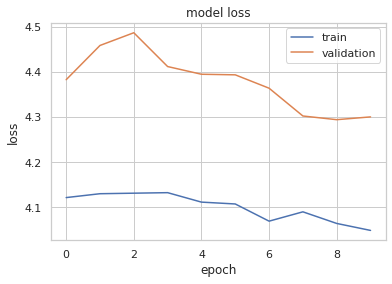

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

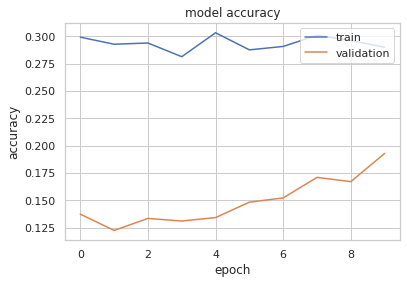

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [21]:
train_loss, train_accu = fernet.evaluate(training_set)
validaton_loss, validation_accu = fernet.evaluate(validation_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, validation_accu*100))

111/111 [==============================] - 72s 648ms/step - loss: 4.2571 - accuracy: 0.2097
final train accuracy = 19.64 , validation accuracy = 20.97


# Result

Confusion Matrix
[[3060    0   40  251  418  138   86]
 [ 329    0    2   29   45   22    9]
 [3085    0   49  285  423  158  103]
 [5451    0   75  493  713  255  177]
 [3806    0   57  348  458  195  118]
 [3776    0   54  347  490  168  103]
 [2423    0   39  222  308  131   82]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.77      0.24      3993
     disgust       0.00      0.00      0.00       436
        fear       0.16      0.01      0.02      4103
       happy       0.25      0.07      0.11      7164
     neutral       0.16      0.09      0.12      4982
         sad       0.16      0.03      0.06      4938
    surprise       0.12      0.03      0.04      3205

    accuracy                           0.15     28821
   macro avg       0.14      0.14      0.08     28821
weighted avg       0.17      0.15      0.10     28821



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


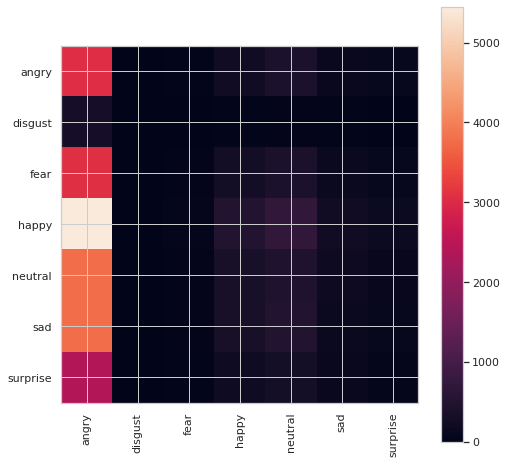

In [22]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[ 738    0    8   79   74   23   38]
 [  86    0    0    9    7    5    4]
 [ 792    0   16   62   86   33   39]
 [1368    0   27  121  171   65   73]
 [ 923    0   18   82   85   44   64]
 [ 864    0   14   87  106   28   40]
 [ 591    0    7   57   64   38   40]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.77      0.23       960
     disgust       0.00      0.00      0.00       111
        fear       0.18      0.02      0.03      1028
       happy       0.24      0.07      0.10      1825
     neutral       0.14      0.07      0.09      1216
         sad       0.12      0.02      0.04      1139
    surprise       0.13      0.05      0.07       797

    accuracy                           0.15      7076
   macro avg       0.14      0.14      0.08      7076
weighted avg       0.17      0.15      0.09      7076



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


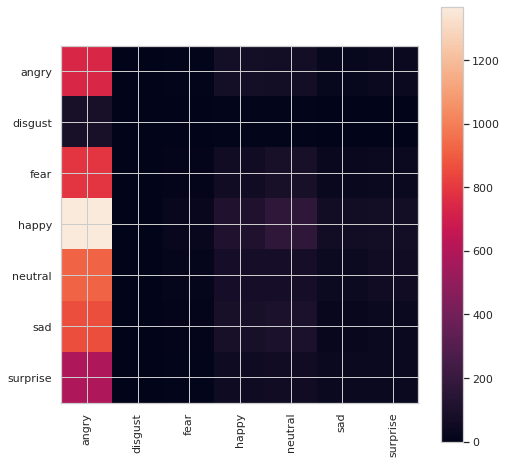

In [23]:
y_pred = fernet.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(validation_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)